In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

# ipywidgets used to interact with graphs
from ipywidgets import interact

# Increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use('fivethirtyeight')

# This makes sure that graphs render in your notebook
%matplotlib inline

In [2]:
# Import machine-learning tools
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

In [3]:
churn = pd.read_csv('./data/Churn_Modelling.csv')
churn['Gender'] = churn.Gender.map({'Female': 0, 'Male': 1})
churn.drop(columns=['RowNumber','CustomerId','Surname'], inplace = True)

churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


**Credit Score of customer**

**Country of customer** - 0/France, 1/Germany, 2/Spain

**Gender of customer** - 0/Female, 1/Male

**Age of customer**

**Tenure of customer** - time of bond with company

**Balance amount currently left**

**Number of products customer owns**

**Has credit card** - 0/no, 1/yes

**Is an active member of company** - 0/no, 1/yes

**Estimated salary of customer** - *target variable*

**Exited from company** - 0/no, 1/yes 

In [4]:
# Credit score (350 - 850) mean approx.650
# Age (18 - 92) mean approx. 39
# Tenure (0 - 10) mean approx. 5
# Balance (0 - 250,898) mean approx. 76,486
# Number of products () mean approx. 
# Salary (11.5 - 199,992) mean approx. 100,090

# Should normalize numericals above except for Salary

In [5]:
churn.shape

(10000, 11)

In [6]:
# Dummy-code the Geography column
dummy_churn = pd.get_dummies(data=churn, columns=['Geography'])

dummy_churn.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [7]:
# Standardize numerical columns
cols_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance']

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dummy_churn[cols_to_scale] = scaler.fit_transform(dummy_churn[cols_to_scale])

dummy_churn.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,0,0.324324,0.2,0.000000,1,1,1,101348.88,1,1,0,0
1,0.516,0,0.310811,0.1,0.334031,1,0,1,112542.58,0,0,0,1
2,0.304,0,0.324324,0.8,0.636357,3,1,0,113931.57,1,1,0,0
3,0.698,0,0.283784,0.1,0.000000,2,0,0,93826.63,0,1,0,0
4,1.000,0,0.337838,0.2,0.500246,1,1,1,79084.10,0,0,0,1


In [9]:
# Create feature matrix and target variable
X = dummy_churn.drop('EstimatedSalary', axis=1)
y = dummy_churn.EstimatedSalary

In [10]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,0,0.324324,0.2,0.000000,1,1,1,1,1,0,0
1,0.516,0,0.310811,0.1,0.334031,1,0,1,0,0,0,1
2,0.304,0,0.324324,0.8,0.636357,3,1,0,1,1,0,0
3,0.698,0,0.283784,0.1,0.000000,2,0,0,0,1,0,0
4,1.000,0,0.337838,0.2,0.500246,1,1,1,0,0,0,1


In [11]:
# Train-test-split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
# Tune MLP model for high-level parameters using RandomizedSearchCV (WARNING! Slow...)
param_distribs = {'activation':['identity', 'tanh', 'logistic', 'relu'], 
                  'solver':['lbfgs', 'sgd', 'adam'], 
                  'alpha':np.arange(0.0001, 100),
                  'learning_rate':['constant', 'invscaling', 'adaptive']}

mlp = MLPRegressor(max_iter=1000000, random_state=42)
random_mlp = RandomizedSearchCV(mlp, param_distribs, n_iter=10, cv=3)
random_mlp.fit(X, y)

print("Best parameter values:", random_mlp.best_params_)
print("With best score of:", np.round(random_mlp.best_score_, 2))

C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maxi

C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\base.py", line 706, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "C:\Users\shmel\Anaconda3\lib\site-packages\sklea

Best parameter values: {'solver': 'sgd', 'learning_rate': 'constant', 'alpha': 65.0001, 'activation': 'relu'}
With best score of: -0.0


In [31]:
# Use function for tuning hidden_layer_sizes parameter, start with 2
def mlp_regression(X_train, y_train, X_test, y_test, num_neurons=2):
    reg = MLPRegressor(hidden_layer_sizes=(num_neurons,), 
                            activation='relu', 
                            solver='sgd', 
                            alpha=65.0001,  
                            learning_rate='constant', 
                            max_iter=100000, 
                            random_state=42)
    reg.fit(X_train, y_train)
    predictions = reg.predict(X_test)
    score = np.round(mean_squared_error(y_test, predictions), 2)
    print("Average MSE score:", str(score))


In [32]:
mlp_regression(X_train, y_train, X_test, y_test)

Average MSE score: 3373565509.31


In [33]:
mlp_regression(X_train, y_train, X_test, y_test, num_neurons=4)

Average MSE score: 3373248921.35


In [34]:
mlp_regression(X_train, y_train, X_test, y_test, num_neurons=5)

Average MSE score: 3373372000.02


In [ ]:
# Ideal number of neurons per hidden layer appears to be 4 - huge MSE score though!!

In [ ]:
# Use GridSearchCV to tune hidden_layer_sizes if that doesn't work!

In [17]:
# Train new model with tuned parameters
mlp_reg = MLPRegressor(hidden_layer_sizes=(4,), 
                            activation='relu', 
                            solver='sgd', 
                            alpha=65.0001,  
                            learning_rate='constant', 
                            max_iter=100000, 
                            random_state=42)

mlp_reg.fit(X_train, y_train)

Iteration 1, loss = 2709380438341272343674880.00000000
Iteration 2, loss = 3725261132697478035931136.00000000
Iteration 3, loss = 2911316750816390162677760.00000000
Iteration 4, loss = 2242738520594059899174912.00000000
Iteration 5, loss = 1727117151915643622129664.00000000
Iteration 6, loss = 1330030300843251303710720.00000000
Iteration 7, loss = 1024238728439327851806720.00000000
Iteration 8, loss = 788752683042566349783040.00000000
Iteration 9, loss = 607407997442657206927360.00000000
Iteration 10, loss = 467756856221874572492800.00000000
Iteration 11, loss = 360213361470035464290304.00000000
Iteration 12, loss = 277395540130810524860416.00000000
Iteration 13, loss = 213618632497256305000448.00000000
Iteration 14, loss = 164504880390220030148608.00000000
Iteration 15, loss = 126683030201257020096512.00000000
Iteration 16, loss = 97556924164827888222208.00000000
Iteration 17, loss = 75127295561072033923072.00000000
Iteration 18, loss = 57854535561050083819520.00000000
Iteration 19, l

Iteration 183, loss = 1642700472.68179893
Iteration 184, loss = 1642707891.16216207
Iteration 185, loss = 1642717795.96766829
Iteration 186, loss = 1642754083.67246771
Iteration 187, loss = 1642690153.59456158
Iteration 188, loss = 1642709272.44804645
Iteration 189, loss = 1642802148.63966346
Iteration 190, loss = 1642684506.55518818
Iteration 191, loss = 1642706024.74996042
Iteration 192, loss = 1642694336.50352240
Iteration 193, loss = 1642697666.63807726
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(alpha=65.0001, hidden_layer_sizes=(4,), max_iter=100000,
             random_state=42, solver='sgd', verbose=True)

In [18]:
# Create predictions and visualize data
y_pred = mlp_reg.predict(X_test)
y_pred

array([99664.8913556, 99664.8913556, 99664.8913556, ..., 99664.8913556,
       99664.8913556, 99664.8913556])

In [19]:
# Using R2 metric from sklearn - 0% means model is not adequate
print("R2 test score:", np.round(r2_score(y_pred, y_test), 2))

R2 test score: 0.0


In [20]:
# Evaluation on test set shows only 0% variability accounted for
print("R2 test score:", np.round(mlp_reg.score(X_test, y_test), 2))

R2 test score: -0.0


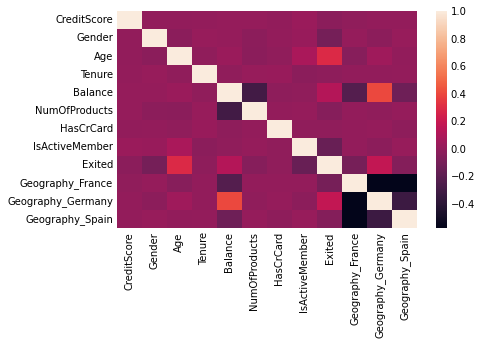

In [21]:
# There is indication of multicollinearity - show correlation matrix
sns.heatmap(X.corr());

In [ ]:
# 'Age' and 'Exited' highly correlated
# 'Geography_Germany' and 'Balance' highly correlated
# Remove variables 'Geography_Germany' and 'Exited' may improve model performance

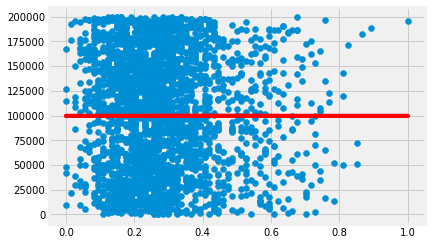

In [30]:
# Visualize distribution of true labels against predicted labels - BLEURGH!
plt.scatter(X_test['Age'], y_test)
plt.plot(X_test['Age'], y_pred, color='red')
#y_pred.shape

In [28]:
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [29]:
df_temp.head()

,Actual,Predicted
3287,82867.55,99664.891356
3769,1055.66,99664.891356
1280,73873.65,99664.891356
7807,36639.25,99664.891356
9793,90928.48,99664.891356
